# Kaggle 10 monkeys 图像分类实战

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

1.13.1
sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)
matplotlib 2.2.3
numpy 1.16.2
pandas 0.22.0
sklearn 0.19.1
tensorflow 1.13.1
tensorflow._api.v1.keras 2.2.4-tf


In [3]:
def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

solve_cudnn_error()

## 数据读取

In [4]:
# 判断文件存在
train_dir = 'training'
valid_dir = 'validation'
label_file = 'monkey_labels.txt'
print(os.path.exists(train_dir))
print(os.path.exists(valid_dir))
print(os.path.exists(label_file))

print(os.listdir(train_dir))
print(os.listdir(valid_dir))

True
True
True
['n4', 'n3', 'n8', 'n7', 'n1', 'n2', 'n5', 'n0', 'n9', 'n6']
['n4', 'n3', 'n8', 'n7', 'n1', 'n2', 'n5', 'n0', 'n9', 'n6']


In [5]:
# 读取labels
labels = pd.read_csv(label_file, header=0)
print(labels)

   Label     Latin Name              Common Name                     \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

    Train Images    Validation Images  
0             131                  26  
1             139                  28  
2             137                  27  
3             152                  30  
4             131 

### 对图像进行数据增强

In [6]:
# 将图片转化成同一尺寸
height = 128
width = 128
channels = 3
batch_size = 64
num_classes = 10

# 读取图片并增强
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale= 1./255, # 缩放到0-1之间
    rotation_range= 40, # 旋转范围
    width_shift_range= 0.2, # 水平位移
    height_shift_range= 0.2, # 竖直平移
    shear_range= 0.2, # 剪切范围
    zoom_range= 0.2, # 缩放范围
    horizontal_flip= True, # 随机水平翻转
    fill_mode= 'nearest', # 对空白位置的填充规则
)
# 按照文件夹进行分类，进行数据增强
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size = (height, width), batch_size = batch_size,
    seed = 7, shuffle = True, class_mode = 'categorical')

valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale= 1./255, # 缩放到0-1之间
)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir, target_size = (height, width), batch_size = batch_size,
    seed = 7, shuffle = False, class_mode = 'categorical')

train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
1098 272


In [7]:
for i in range(1):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(64, 128, 128, 3) (64, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.

## 基础模型构建--CNN

In [8]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
                        input_shape=[width, height, channels]),
    keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv

In [9]:
# 训练
epochs = 10
history = model.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=epochs,
                              validation_data=valid_generator,
                              validation_steps= valid_num // batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
18/18 [==============================] - 31s 2s/step - loss: 2.2521 - acc: 0.1512 - val_loss: 2.1272 - val_acc: 0.1985
Epoch 2/10
18/18 [==============================] - 26s 1s/step - loss: 2.0441 - acc: 0.2641 - val_loss: 1.8041 - val_acc: 0.3456
Epoch 3/10
18/18 [==============================] - 27s 1s/step - loss: 1.8376 - acc: 0.3151 - val_loss: 1.6674 - val_acc: 0.4044
Epoch 4/10
18/18 [==============================] - 27s 1s/step - loss: 1.7027 - acc: 0.3807 - val_loss: 1.5530 - val_acc: 0.4228
Epoch 5/10
18/18 [==============================] - 27s 1s/step - loss: 1.5947 - acc: 0.4299 - val_loss: 1.5608 - val_acc: 0.4412
Epoch 6/10
18/18 [==============================] - 27s 1s/step - loss: 1.5334 - acc: 0.4217 - val_loss: 1.5559 - val_acc: 0.4890
Epoch 7/10
18/18 [==============================] - 27s 1s/step - loss: 1.5473 - acc: 0.4353 - val_loss: 1.4228 - val_acc: 0.4559
Epoch 8/10
18/18 [========================

In [10]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


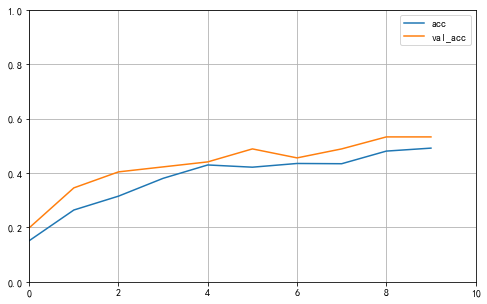

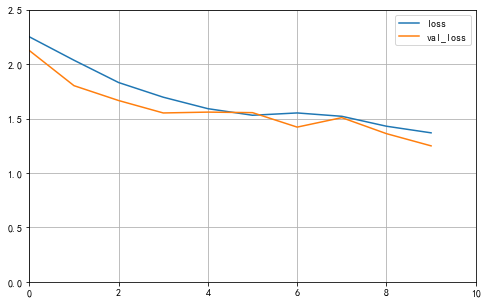

In [11]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'acc', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 2.5)

## 迁移学习--RestNet50 finetune
### 数据增强

In [12]:
# 将图片转化成同一尺寸
height = 224
width = 224
channels = 3
batch_size = 24
num_classes = 10

# 读取图片并增强
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input,
    rotation_range= 40, # 旋转范围
    width_shift_range= 0.2, # 水平位移
    height_shift_range= 0.2, # 竖直平移
    shear_range= 0.2, # 剪切范围
    zoom_range= 0.2, # 缩放范围
    horizontal_flip= True, # 随机水平翻转
    fill_mode= 'nearest', # 对空白位置的填充规则
)
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size = (height, width), batch_size = batch_size,
    seed = 7, shuffle = True, class_mode = 'categorical')

valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir, target_size = (height, width), batch_size = batch_size,
    seed = 7, shuffle = False, class_mode = 'categorical')

train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
1098 272


In [13]:
for i in range(1):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(24, 224, 224, 3) (24, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


### resnet50 finetune 模型构建

In [15]:
resnet50_fine_tune = keras.models.Sequential()
resnet50_fine_tune.add(keras.applications.ResNet50(
    include_top = False, pooling = 'avg', weights = 'imagenet'))
resnet50_fine_tune.add(keras.layers.Dense(num_classes, activation='softmax'))
resnet50_fine_tune.layers[0].trainable = False

resnet50_fine_tune.compile(
    loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
resnet50_fine_tune.summary()

A local file was found, but it seems to be incomplete or outdated because the md5 file hash does not match the original value of a268eb855778b3df3c7506639542a6af so we will re-download the data.
94658560/94653016 [==============================] - 315s 3us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [16]:
epochs = 10
history_resnet = resnet50_fine_tune.fit_generator(
    train_generator,
    steps_per_epoch= train_num // batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps= valid_num // batch_size)

Epoch 1/10
46/46 [==============================] - 39s 844ms/step - loss: 1.5982 - acc: 0.5064 - val_loss: 0.7137 - val_acc: 0.8309
Epoch 2/10
46/46 [==============================] - 35s 754ms/step - loss: 0.7217 - acc: 0.8525 - val_loss: 0.4170 - val_acc: 0.9154
Epoch 3/10
46/46 [==============================] - 35s 760ms/step - loss: 0.4602 - acc: 0.9244 - val_loss: 0.2905 - val_acc: 0.9522
Epoch 4/10
46/46 [==============================] - 35s 756ms/step - loss: 0.3806 - acc: 0.9244 - val_loss: 0.2420 - val_acc: 0.9669
Epoch 5/10
46/46 [==============================] - 35s 760ms/step - loss: 0.3117 - acc: 0.9508 - val_loss: 0.2282 - val_acc: 0.9669
Epoch 6/10
46/46 [==============================] - 35s 759ms/step - loss: 0.2664 - acc: 0.9536 - val_loss: 0.1871 - val_acc: 0.9706
Epoch 7/10
46/46 [==============================] - 35s 753ms/step - loss: 0.2420 - acc: 0.9517 - val_loss: 0.1616 - val_acc: 0.9779
Epoch 8/10
46/46 [==============================] - 35s 758ms/step - 

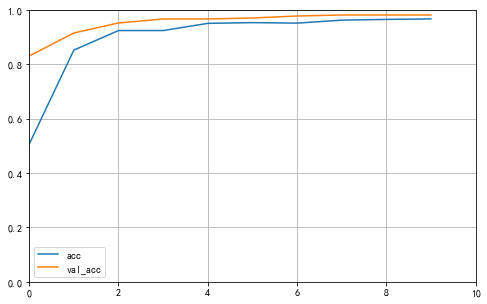

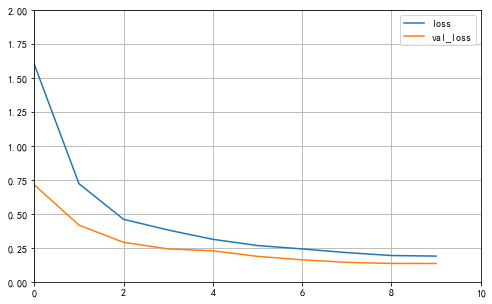

In [18]:
plot_learning_curves(history_resnet, 'acc', epochs, 0, 1)
plot_learning_curves(history_resnet, 'loss', epochs, 0, 2)

## 另一种resnet50 finetune，对resnet最后几层进行训练

In [19]:
resnet50 = keras.applications.ResNet50(
    include_top = False, pooling = 'avg', weights = 'imagenet')
resnet50.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [20]:
for layer in resnet50.layers[0:-5]:
    layer.trainable = False

resnet50_new = keras.models.Sequential([
    resnet50,
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50_new.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
resnet50_new.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 1,075,210
Non-trainable params: 22,532,992
_________________________________________________________________


In [21]:
epochs = 10
history_resnet_new = resnet50_new.fit_generator(
    train_generator,
    steps_per_epoch= train_num // batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps= valid_num // batch_size)

Epoch 1/10
46/46 [==============================] - 36s 789ms/step - loss: 1.3233 - acc: 0.6184 - val_loss: 0.4070 - val_acc: 0.9228
Epoch 2/10
46/46 [==============================] - 35s 752ms/step - loss: 0.5248 - acc: 0.9126 - val_loss: 0.2020 - val_acc: 0.9559
Epoch 3/10
46/46 [==============================] - 35s 756ms/step - loss: 0.3561 - acc: 0.9372 - val_loss: 0.1853 - val_acc: 0.9522
Epoch 4/10
46/46 [==============================] - 35s 750ms/step - loss: 0.2651 - acc: 0.9581 - val_loss: 0.1433 - val_acc: 0.9669
Epoch 5/10
46/46 [==============================] - 35s 763ms/step - loss: 0.2176 - acc: 0.9590 - val_loss: 0.1485 - val_acc: 0.9559
Epoch 6/10
46/46 [==============================] - 35s 754ms/step - loss: 0.2071 - acc: 0.9581 - val_loss: 0.1351 - val_acc: 0.9485
Epoch 7/10
46/46 [==============================] - 35s 756ms/step - loss: 0.1903 - acc: 0.9608 - val_loss: 0.1494 - val_acc: 0.9449
Epoch 8/10
46/46 [==============================] - 35s 752ms/step - 

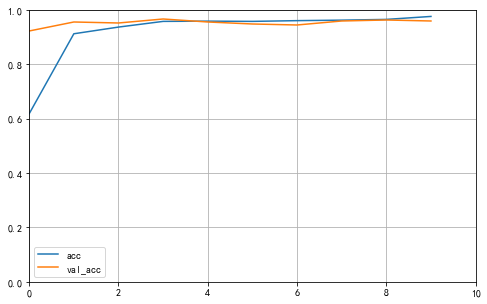

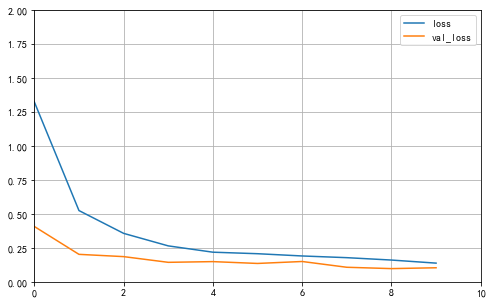

In [23]:
plot_learning_curves(history_resnet_new, 'acc', epochs, 0, 1)
plot_learning_curves(history_resnet_new, 'loss', epochs, 0, 2)